In [71]:
import numpy as np
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from shapely.geometry import LineString, Point
from matplotlib import cm
import os


In [8]:
def to_dB(array):
    array_db = 10.0 * np.log10(array)
    return array_db

In [69]:
velocity_tif = '/home/gyjai/leeds_drives/capella/baltoro/CAPELLA_20210715_20210723_GEC_128/CAP_20210715CAP_20210723.c_vel.tiff'
sar_tif = '/home/gyjai/ft_outputs/capella/capella_8/CAP_20210715_CAP_20210723/CAP_20210715/CAPELLA_C03_SP_GEC_HH_20210715050155_20210715050217.tif'



# Open the raster files
with rasterio.open(velocity_tif) as velocity_src:
    velocity_data = velocity_src.read(1)
    velocity_transform = velocity_src.transform
    


with rasterio.open(sar_tif) as sar_src:
    sar_data = sar_src.read(1)
    sar_transform = sar_src.transform
    
sar_data_db = to_dB(sar_data)


RasterioIOError: /home/gyjai/leeds_drives/capella/baltoro/CAPELLA_20210715_20210723_GEC_128/CAP_20210715CAP_20210723.c_vel.tiff: No such file or directory

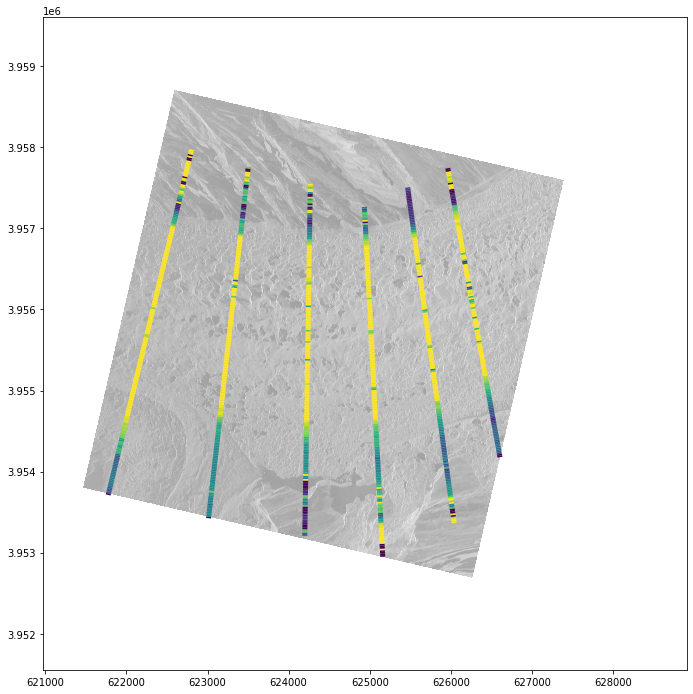

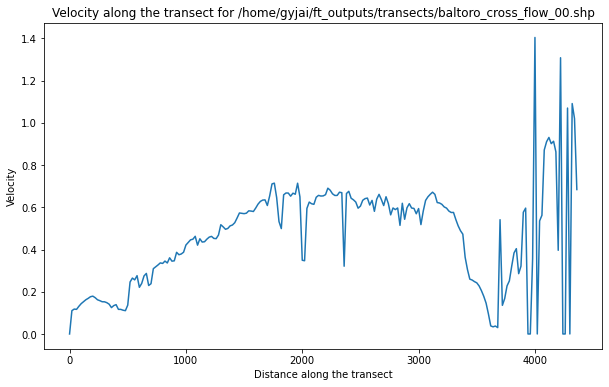

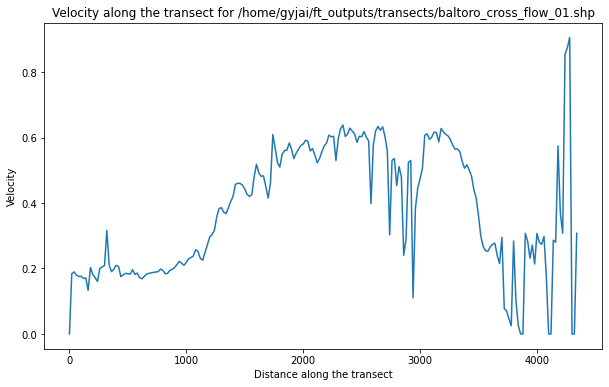

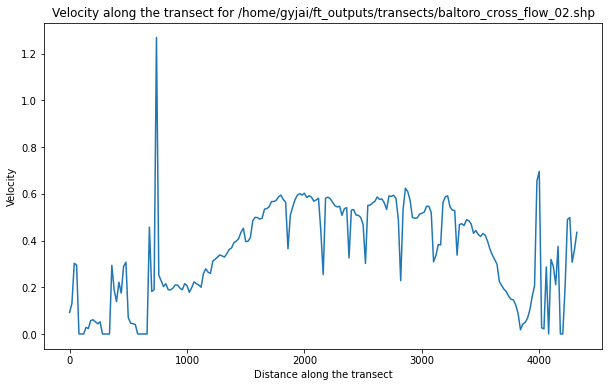

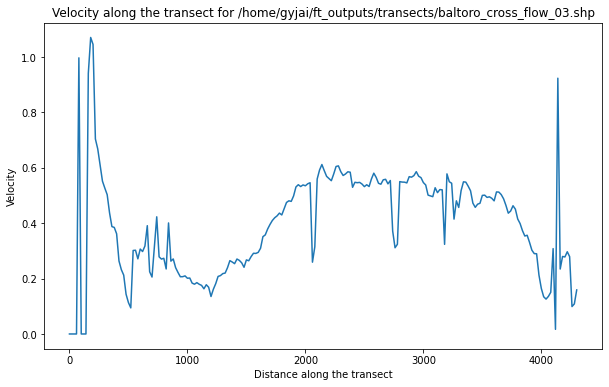

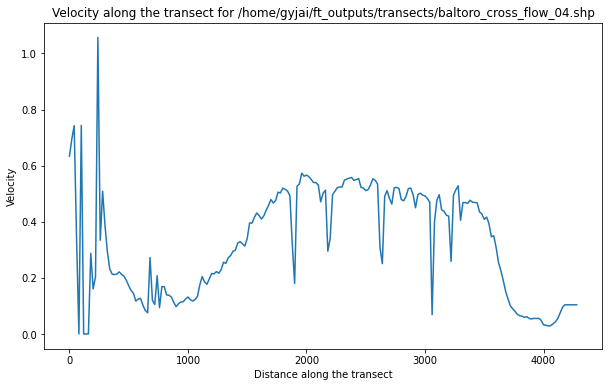

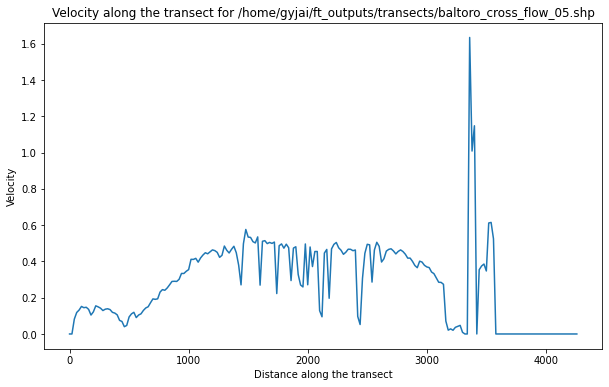

In [76]:
path = '/home/gyjai/ft_outputs/transects/'

sp00 = os.path.join(path, 'baltoro_cross_flow_00.shp')
sp01 = os.path.join(path, 'baltoro_cross_flow_01.shp')
sp02 = os.path.join(path, 'baltoro_cross_flow_02.shp')
sp03 = os.path.join(path, 'baltoro_cross_flow_03.shp')
sp04 = os.path.join(path, 'baltoro_cross_flow_04.shp')
sp05 = os.path.join(path, 'baltoro_cross_flow_05.shp')

# Your list of shapefiles
shapefiles = [sp00,sp01,sp02,sp03,sp04,sp05]  # replace with your shapefiles

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 12))  # set the size of the figure

# Plot the SAR image in grayscale
show(sar_data_db, transform=sar_transform, ax=ax, cmap='gray')

# Normalize the velocities to [0, 1] for color mapping
min_bound = 0  # Set the lower bound of your color scale
max_bound = 0.4  # Set the upper bound of your color scale
norm_velocity = plt.Normalize(min_bound, max_bound)

# Get the colormap
cmap = cm.viridis

# Sample points every 50 meters
sampling_distance = 20  # in meters

# Iterate over each shapefile
for shapefile in shapefiles:
    # Read the GeoDataFrame
    gdf = gpd.read_file(shapefile)
    
    for index, shape_row in gdf.iterrows():
        segments = []
        colors = []
        total_length = shape_row['geometry'].length
        points = [shape_row['geometry'].interpolate(distance) for distance in distances]
        velocities = []
        
        for i in range(len(points) - 1):  # Stop before the last point
            segment = [points[i].coords[0], points[i+1].coords[0]]
            segments.append(segment)

            # Get the midpoint of the segment
            mid_x = (segment[0][0] + segment[1][0]) / 2
            mid_y = (segment[0][1] + segment[1][1]) / 2

            # Convert the point's coordinates to raster's array indices
            row, col = velocity_src.index(mid_x, mid_y)

            # Get the velocity value at this point
            velocity = velocity_data[row, col]
            velocities.append(velocity)

            # Normalize the velocity and get the corresponding color
            color = cmap(norm_velocity(velocity))
            colors.append(color)
            
            
        distances = distances[:len(velocities)]


        # Create a LineCollection for the line with color for each segment
        lc = LineCollection(segments, 
                            colors=colors, 
                            linewidths=5,
                            transform=ax.transData)

        # Add the LineCollection to the axes
        ax.add_collection(lc)

        # Create a separate figure for the line plot of velocity vs. distance
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        ax2.plot(distances, velocities)
        ax2.set_xlabel('Distance along the transect')
        ax2.set_ylabel('Velocity')
        ax2.set_title(f'Velocity along the transect for {shapefile}')

plt.show()


    

In [68]:

# Create a list to store each Point and its velocity
points = []

# Go through each row (geometry) in the GeoDataFrame
for index, shape_row in gdf.iterrows():
    # Get the length of the LineString
    length = shape_row['geometry'].length

    # Generate points every 20 meters along the LineString
    for distance in np.arange(0, length, 5):
        # Interpolate the point at this distance
        point = shape_row['geometry'].interpolate(distance)

        # Convert the point's coordinates to raster's array indices
        row, col = velocity_src.index(point.x, point.y)
        
        # Get the velocity value at this point
        velocity = velocity_data[row, col]
        
        # Append the point and velocity to the list
        points.append((point, velocity))

# Create a GeoDataFrame from the points and velocities
gdf_points = gpd.GeoDataFrame(points, columns=['geometry', 'velocity'], 
                               crs=gdf.crs)



transect_shp = '/home/gyjai/ft_outputs/transects/baltoro_transect_01.shp'

# Write the GeoDataFrame to a shapefile
gdf_points.to_file(transect_shp)

In [77]:
def create_velocity_points(input_shapefile, velocity_src, velocity_data, output_directory):
    # Load the shapefile into a GeoDataFrame
    gdf = gpd.read_file(input_shapefile)

    # Create a list to store each Point and its velocity
    points = []

    # Go through each row (geometry) in the GeoDataFrame
    for index, shape_row in gdf.iterrows():
        # Get the length of the LineString
        length = shape_row['geometry'].length

        # Generate points every 20 meters along the LineString
        for distance in np.arange(0, length, 5):
            # Interpolate the point at this distance
            point = shape_row['geometry'].interpolate(distance)

            # Convert the point's coordinates to raster's array indices
            row, col = velocity_src.index(point.x, point.y)
            
            # Get the velocity value at this point
            velocity = velocity_data[row, col]
            
            # Append the point and velocity to the list
            points.append((point, velocity))

    # Create a GeoDataFrame from the points and velocities
    gdf_points = gpd.GeoDataFrame(points, columns=['geometry', 'velocity'], 
                                   crs=gdf.crs)

    # Generate the output shapefile name
    input_basename = os.path.basename(input_shapefile)
    output_shapefile = os.path.join(output_directory, input_basename)

    # Write the GeoDataFrame to a shapefile
    gdf_points.to_file(output_shapefile)


In [78]:
# Specify the list of input shapefiles and the output directory

input_shapefiles = [sp00,sp01,sp02,sp03,sp04,sp05]

output_directory = '/home/gyjai/ft_outputs/transects/out/'


# Loop over the input shapefiles and create the velocity points for each
for input_shapefile in input_shapefiles:
    create_velocity_points(input_shapefile, velocity_src, velocity_data, output_directory)

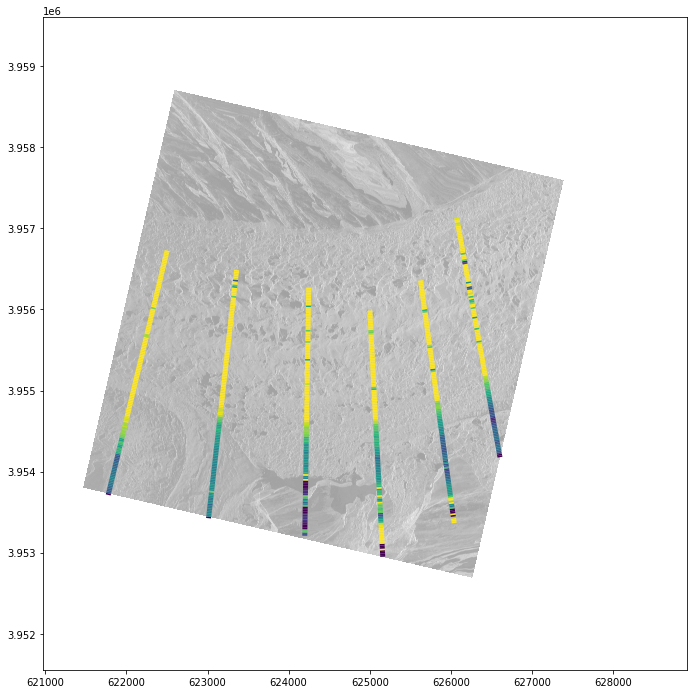

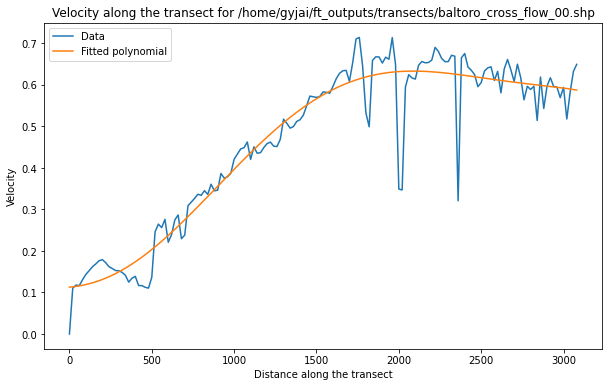

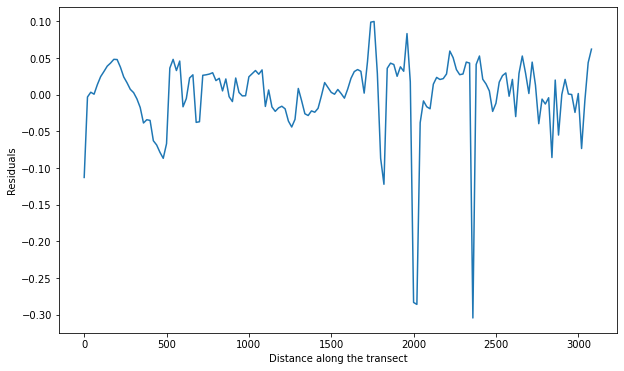

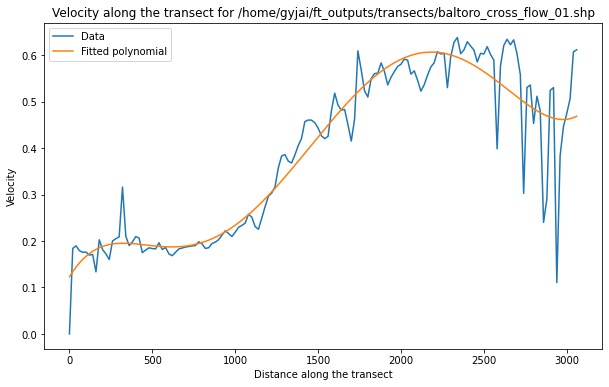

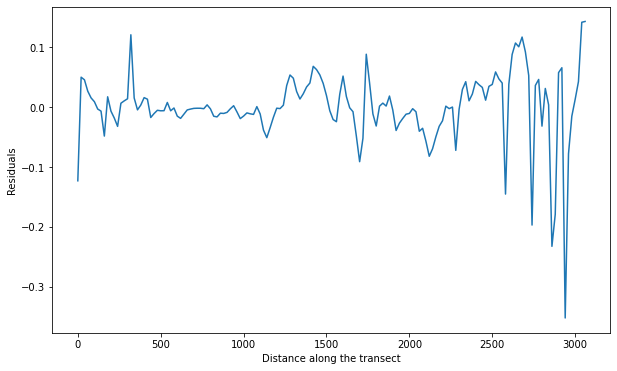

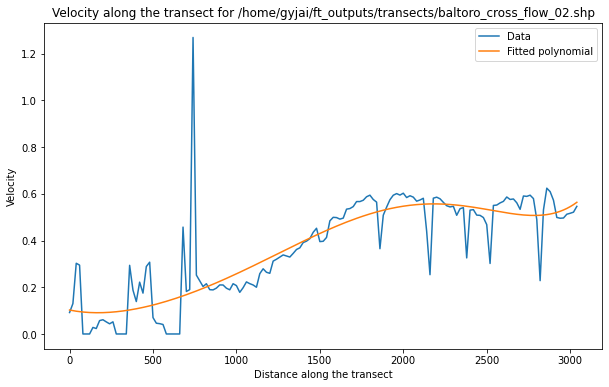

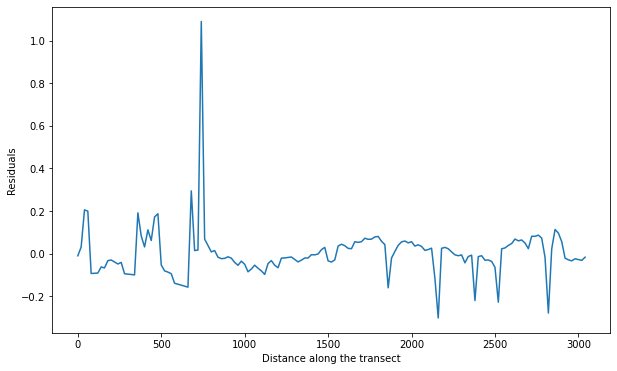

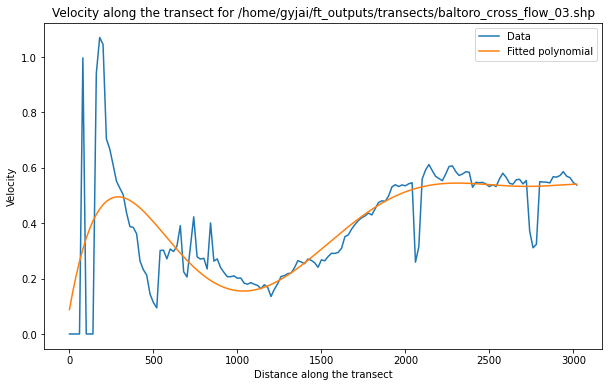

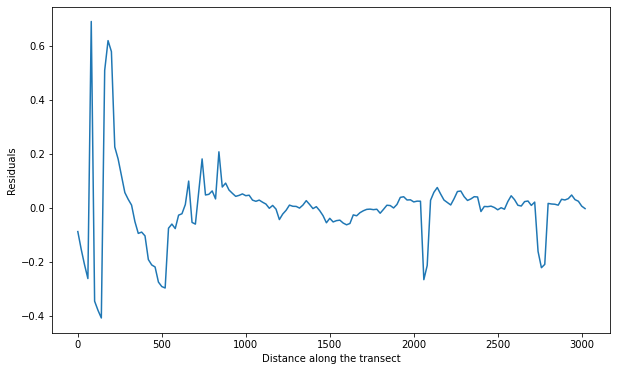

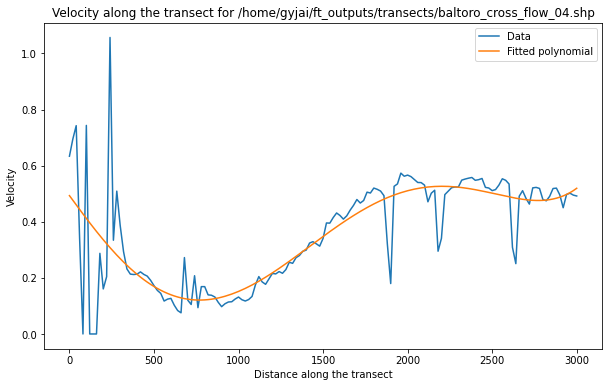

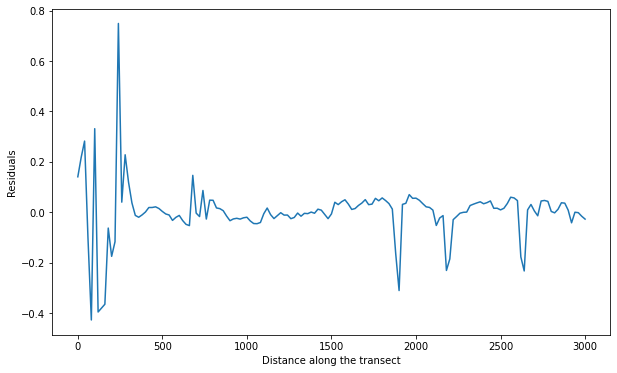

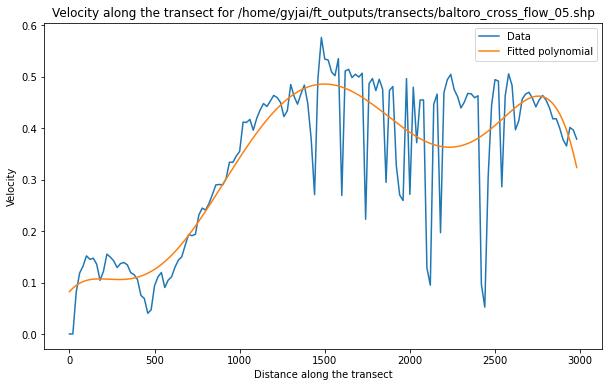

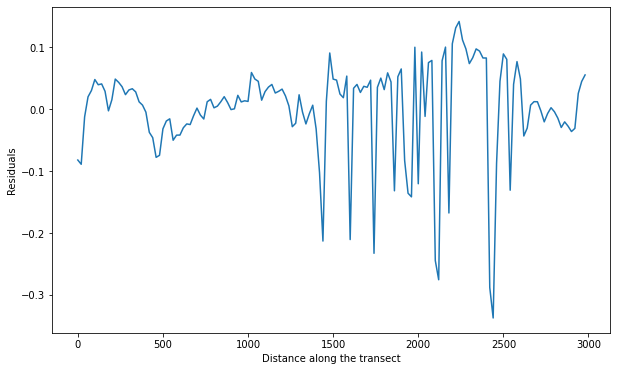

In [85]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 12))  # set the size of the figure

# Plot the SAR image in grayscale
show(sar_data_db, transform=sar_transform, ax=ax, cmap='gray')

# Normalize the velocities to [0, 1] for color mapping
min_bound = 0  # Set the lower bound of your color scale
max_bound = 0.4  # Set the upper bound of your color scale
norm_velocity = plt.Normalize(min_bound, max_bound)

# Get the colormap
cmap = cm.viridis

# Sample points every 50 meters
sampling_distance = 20  # in meters

# Iterate over each shapefile
for shapefile in shapefiles:
    # Read the GeoDataFrame
    gdf = gpd.read_file(shapefile)
    
    for index, shape_row in gdf.iterrows():
        segments = []
        colors = []
        total_length = shape_row['geometry'].length
        points = [shape_row['geometry'].interpolate(distance) for distance in distances]
        velocities = []
        
        for i in range(len(points) - 1):  # Stop before the last point
            segment = [points[i].coords[0], points[i+1].coords[0]]
            segments.append(segment)

            # Get the midpoint of the segment
            mid_x = (segment[0][0] + segment[1][0]) / 2
            mid_y = (segment[0][1] + segment[1][1]) / 2

            # Convert the point's coordinates to raster's array indices
            row, col = velocity_src.index(mid_x, mid_y)

            # Get the velocity value at this point
            velocity = velocity_data[row, col]

            velocities.append(velocity)

            # Normalize the velocity and get the corresponding color
            color = cmap(norm_velocity(velocity))
            colors.append(color)
            
        distances = distances[:len(velocities)]

        # Fit a quadratic polynomial to the data
        poly_coeffs = np.polyfit(distances, velocities, 6)
        
        # Compute the fitted polynomial values
        fitted_poly = np.polyval(poly_coeffs, distances)
        
        # Compute the residuals
        residuals = velocities - fitted_poly

        # Create a LineCollection for the line with color for each segment
        lc = LineCollection(segments, 
                            colors=colors, 
                            linewidths=5,
                            transform=ax.transData)

        # Add the LineCollection to the axes
        ax.add_collection(lc)

        # Create a separate figure for the line plot of velocity vs. distance
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        ax2.plot(distances, velocities, label='Data')
        ax2.plot(distances, fitted_poly, label='Fitted polynomial')
        ax2.set_xlabel('Distance along the transect')
        ax2.set_ylabel('Velocity')
        ax2.set_title(f'Velocity along the transect for {shapefile}')
        ax2.legend()
        
        # Create a separate figure for the residuals
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        ax3.plot(distances, residuals, label='Residuals')
        ax3.set_xlabel('Distance along the transect')
        ax3.set_ylabel('Residuals')
        ax3.set_title








